In [58]:
#!g++ -Wall fast_integrator.cpp -O3 -march=native -ffast-math -static-gsl -fPIC $(python3 -m pybind11 --includes) -o fast_integrator.so

g++: error: unrecognized command line option ‘-static-gsl’; did you mean ‘-static-pie’?


In [ ]:
# run wsl 

In [59]:
!g++ -Wall fast_integrator.cpp -shared -O3 -march=native -ffast-math -Wl,-Bstatic -lgsl -Wl,-Bdynamic  -fPIC $(python3 -m pybind11 --includes) -o fast_integrator.so

fast_integrator.cpp: In function ‘double calc_line_flux(double, double, double, double, double, double, double, double, double, gsl_integration_workspace*)’:
fast_integrator.cpp:284:14: warning: unused variable ‘status’ [-Wunused-variable]
  284 |     if (auto status = gsl_integration_qags (&iE, 0, t*vmax, 1, 1.49e-08, 50, workspace, &result, &error)){
      |              ^~~~~~


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import emcee_implementation as code


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23 
#pi = np.pi; h = 6.626e-27; c = 3.0e+10; k = 1.38e-16 #cgs

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
wl, flux, error = code.wl, code.flux, code.error

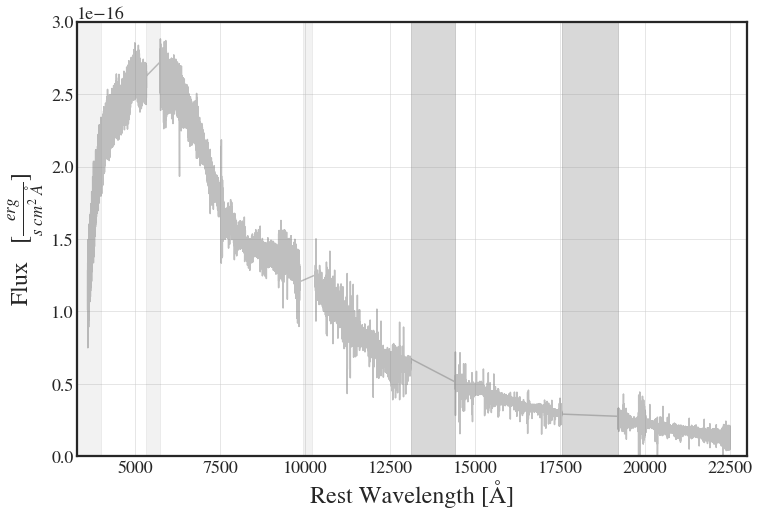

In [4]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [5]:
import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

#### Fit structure

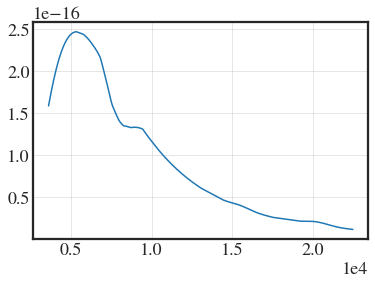

In [6]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./Data/%s_init.json"%OB, 'r') as infile:
    p.load(infile)
code.new = True
new_residual = code.residual(p, wl*1e-10)
plt.plot(wl, new_residual)

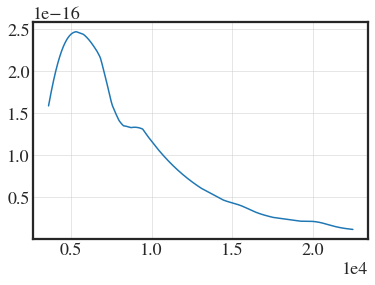

In [7]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./Data/%s_init.json"%OB, 'r') as infile:
    p.load(infile)
code.new = False
old_residual = code.residual(p, wl*1e-10)
plt.plot(wl, old_residual)

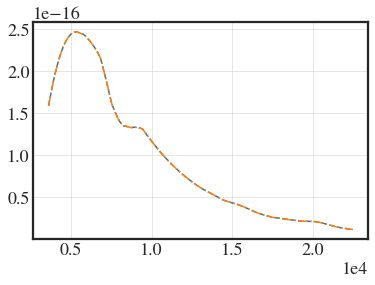

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.plot(wl, new_residual, '--')
plt.plot(wl, old_residual, '-.')
plt.savefig('test.png')

In [9]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./Data/%s_init.json"%OB, 'r') as infile:
    p.load(infile)
code.new = True

start = time.time()
#mi2 = lmfit.minimize(code.residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 8.185704549153645e-07


#### Markov Chain Monto Carlo to sample distribution

XL_1 = 10.000 with 50 walkers, wide gaussian
XL_2 = 20.000 with 50 walkers, narrow gaussian
XL_3 = 100.000 with 22 walkers free sigma
XL_4 = 20.000 with 100 walkers, tight constraint on sigma and gaussians set by XL_3.

In [41]:
import importlib
importlib.reload(code)
#%prun code.optimize(p, use_new=True, nwalkers=32, steps=10)

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

<module 'emcee_implementation' from '/mnt/c/Users/asnep/Downloads/Kilonova/emcee_implementation.py'>

In [56]:
code.use_new  = True
nwalkers = 32
steps    = 50

start = time.time()
%prun sampler = code.optimize(p, use_new, nwalkers, steps)
end = time.time()
print('Time elapsed:',(end-start)/60) 

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]

 Time elapsed: 0.7684115886688232


In [54]:
#np.shape(flatten_chain)

In [55]:
flatten_chain = sampler.get_chain().reshape(-1,9)#.shape
temp  = flatten_chain[:,0]
N     = flatten_chain[:,1]
vphot = flatten_chain[:,2]
vmax  = flatten_chain[:,3]
tau   = flatten_chain[:,4]
ve    = flatten_chain[:,5]



In [48]:
code.construct_p(sampler.get_chain()[0,0])

name,value,initial value,min,max,vary
T,5416.88911,5417,2500.00000,7500.00000,True
N,1.3001e-29,1.3e-29,-inf,inf,True
vphot,0.26998598,0.27,0.00000000,1.00000000,True
vmax,0.33798122,0.338,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,2.30045213,2.3,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.23003205,0.23,0.00000000,1.00000000,True
occult,0.01000009,0.01,0.00000000,2.00000000,True
amp1,0.26000733,0.26,0.00000000,1.00000000,True


In [19]:
{"T": np}

False

In [20]:
dir(sampler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_moves',
 '_previous_state',
 '_random',
 '_weights',
 'acceptance_fraction',
 'acor',
 'backend',
 'blobs',
 'blobs_dtype',
 'chain',
 'compute_log_prob',
 'flatblobs',
 'flatchain',
 'flatlnprobability',
 'get_autocorr_time',
 'get_blobs',
 'get_chain',
 'get_last_sample',
 'get_log_prob',
 'get_value',
 'iteration',
 'lnprobability',
 'log_prob_fn',
 'ndim',
 'nwalkers',
 'params_are_named',
 'pool',
 'random_state',
 'reset',
 'run_mcmc',
 'sample',
 'vectorize']

In [21]:
sampler.params_are_named

TypeError: 'bool' object is not callable

In [43]:
dir(sampler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_moves',
 '_previous_state',
 '_random',
 '_weights',
 'acceptance_fraction',
 'acor',
 'backend',
 'blobs',
 'blobs_dtype',
 'chain',
 'compute_log_prob',
 'flatblobs',
 'flatchain',
 'flatlnprobability',
 'get_autocorr_time',
 'get_blobs',
 'get_chain',
 'get_last_sample',
 'get_log_prob',
 'get_value',
 'iteration',
 'lnprobability',
 'log_prob_fn',
 'ndim',
 'nwalkers',
 'params_are_named',
 'pool',
 'random_state',
 'reset',
 'run_mcmc',
 'sample',
 'vectorize']

In [ ]:
import time
import numpy as np

import emcee

np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

In [ ]:
optimize

sampler = emcee.EnsembleSampler(10, ndim, log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()



In [21]:
from tqdm import tqdm

In [23]:
import time
import numpy as np


def log_prob(theta):
    t = time.time() + np.random.uniform(0.005, 0.008)
    while True:
        if time.time() >= t:
            break
    return -0.5 * np.sum(theta ** 2)
import emcee

np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

You must install the tqdm library to use progress indicators with emcee


Serial took 2.4 seconds


You must install the tqdm library to use progress indicators with emcee


Multiprocessing took 1.0 seconds
2.5 times faster than serial


In [25]:
import multiprocessing
print(multiprocessing.cpu_count())

4


In [24]:
nwalkers, ndim

(32, 5)